INTRO


In [45]:
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt

# Loading base images and coverting them to grayscale
face = cv2.imread("obama.jpg")
body = cv2.imread("trump.jpeg")

face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
body_gray = cv2.cvtColor(body, cv2.COLOR_BGR2GRAY)

# Create empty matrices in the images' shapes
height, width = face_gray.shape
mask = np.zeros((height, width), np.uint8)

height, width, channels = body.shape

FALAR DO dlib E DO MODELO

You can download the model [here](https://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2/download) then just extract it to the same folder as this notebook

https://www.pyimagesearch.com/2019/12/16/training-a-custom-dlib-shape-predictor/

In [46]:
# Loading models and predictors of the dlib library to detect landmarks in both faces
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")

# Getting landmarks for the face that will be swapped into to the body
rect = detector(face_gray)[0]

# This creates a with 68 pairs of integer values — these values are the (x, y)-coordinates of the facial structures 
landmarks = predictor(face_gray, rect)
landmarks_points = [] 

def get_landmarks(landmarks, landmarks_points):
  for n in range(68):
      x = landmarks.part(n).x
      y = landmarks.part(n).y
      landmarks_points.append((x, y))

get_landmarks(landmarks, landmarks_points)

points = np.array(landmarks_points, np.int32)

The Convex Hull of a shape or a group of points is a tight fitting convex boundary around the points or the shape, we are using this to generate a mask around the landmark point over the subject's face.

https://www.learnopencv.com/convex-hull-using-opencv-in-python-and-c/

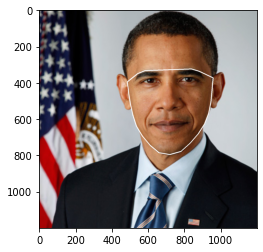

In [47]:
convexhull = cv2.convexHull(points) 

face_cp = face.copy()
plt.imshow(cv2.cvtColor((cv2.polylines(face_cp, [convexhull], True, (255,255,255), 3)), cv2.COLOR_BGR2RGB))

face_image_1 = cv2.bitwise_and(face, face, mask=mask)

Now we can divide the faces in triangles using the landmarks. The triangles will be used to fit the facial features of the first person in the second one's face, this is important because each person's face is shaped diferently and the photos can be taken from different perspectives.
https://www.learnopencv.com/delaunay-triangulation-and-voronoi-diagram-using-opencv-c-python/

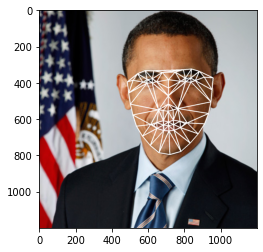

In [48]:
rect = cv2.boundingRect(convexhull)

subdiv = cv2.Subdiv2D(rect) # Creates an instance of Subdiv2D
subdiv.insert(landmarks_points) # Insert points into subdiv
triangles = subdiv.getTriangleList()
triangles = np.array(triangles, dtype=np.int32)

indexes_triangles = []
face_cp = face.copy()

def get_index(arr):
    index = 0
    if arr[0]:
        index = arr[0][0]
    return index

for triangle in triangles :

    # Gets the vertex of the triangle
    pt1 = (triangle[0], triangle[1])
    pt2 = (triangle[2], triangle[3])
    pt3 = (triangle[4], triangle[5])
    
    # Draws a line for each side of the triangle
    cv2.line(face_cp, pt1, pt2, (255, 255, 255), 3,  0)
    cv2.line(face_cp, pt2, pt3, (255, 255, 255), 3,  0)
    cv2.line(face_cp, pt3, pt1, (255, 255, 255), 3,  0)

    index_pt1 = np.where((points == pt1).all(axis=1))
    index_pt1 = get_index(index_pt1)
    index_pt2 = np.where((points == pt2).all(axis=1))
    index_pt2 = get_index(index_pt2)
    index_pt3 = np.where((points == pt3).all(axis=1))
    index_pt3 = get_index(index_pt3)

    # Saves coordinates if the triangle exists and has 3 vertices
    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
        vertices = [index_pt1, index_pt2, index_pt3]
        indexes_triangles.append(vertices)

# Draw delaunay triangles
plt.imshow(cv2.cvtColor(face_cp, cv2.COLOR_BGR2RGB))   

We can now get the landmarks and generate the convex hull for the second person.

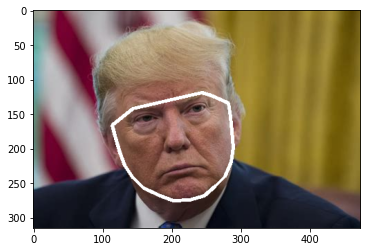

In [49]:
# Getting landmarks for the face that will have the first one swapped into
rect2 = detector(body_gray)[0]

# This creates a with 68 pairs of integer values — these values are the (x, y)-coordinates of the facial structures 
landmarks_2 = predictor(body_gray, rect2)
landmarks_points2 = []

# Uses the function declared previously to get a list of the landmark coordinates
get_landmarks(landmarks_2, landmarks_points2)

# Generates a convex hull for the second person
points2 = np.array(landmarks_points2, np.int32)
convexhull2 = cv2.convexHull(points2)

body_cp = body.copy()
plt.imshow(cv2.cvtColor((cv2.polylines(body_cp, [convexhull2], True, (255,255,255), 3)), cv2.COLOR_BGR2RGB))

To fit the first person's face to the second one's body, we  will distort the triangles generated to so that they have the same dimentions of the ones created with the landmarks of the second person, this will warp the face of the first person to fit the facial features of the second one.

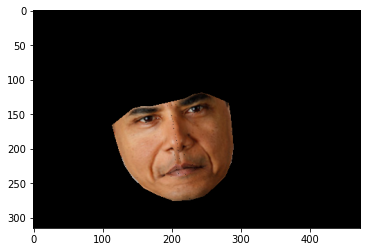

In [50]:
lines_space_new_face = np.zeros((height, width, channels), np.uint8)
body_new_face = np.zeros((height, width, channels), np.uint8)

height, width = face_gray.shape
lines_space_mask = np.zeros((height, width), np.uint8)


for triangle in indexes_triangles:

    # Coordinates of the first person's delaunay triangles
    pt1 = landmarks_points[triangle[0]]
    pt2 = landmarks_points[triangle[1]]
    pt3 = landmarks_points[triangle[2]]

    # Gets the delaunay triangles
    (x, y, widht, height) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
    cropped_triangle = face[y: y+height, x: x+widht]
    cropped_mask = np.zeros((height, widht), np.uint8)

    # Fills triangle to generate the mask
    points = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
    cv2.fillConvexPoly(cropped_mask, points, 255)

    # Draws lines for the triangles
    cv2.line(lines_space_mask, pt1, pt2, 255)
    cv2.line(lines_space_mask, pt2, pt3, 255)
    cv2.line(lines_space_mask, pt1, pt3, 255)

    lines_space = cv2.bitwise_and(face, face, mask=lines_space_mask)

    # Calculates the delaunay triangles of the second person's face

    # Coordinates of the first person's delaunay triangles
    pt1 = landmarks_points2[triangle[0]]
    pt2 = landmarks_points2[triangle[1]]
    pt3 = landmarks_points2[triangle[2]]

    # Gets the delaunay triangles
    (x, y, widht, height) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
    cropped_mask2 = np.zeros((height,widht), np.uint8)

    # Fills triangle to generate the mask
    points2 = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
    cv2.fillConvexPoly(cropped_mask2, points2, 255)

    # Deforms the triangles to fit the subject's face : https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html
    points =  np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)  # Warps the content of the first triangle to fit in the second one
    dist_triangle = cv2.warpAffine(cropped_triangle, M, (widht, height))
    dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=cropped_mask2)

    # Joins all the distorted triangles to make the face mask to fit in the second person's features
    body_new_face_rect_area = body_new_face[y: y+height, x: x+widht]
    body_new_face_rect_area_gray = cv2.cvtColor(body_new_face_rect_area, cv2.COLOR_BGR2GRAY)

    # Creates a mask
    masked_triangle = cv2.threshold(body_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=masked_triangle[1])

    # Adds the piece to the face mask
    body_new_face_rect_area = cv2.add(body_new_face_rect_area, dist_triangle)
    body_new_face[y: y+height, x: x+widht] = body_new_face_rect_area
  
plt.imshow(cv2.cvtColor(body_new_face, cv2.COLOR_BGR2RGB))

Finally we can swap the face masks 

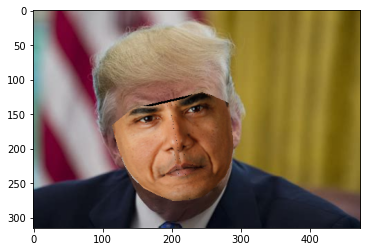

In [51]:
body_face_mask = np.zeros_like(body_gray)
body_head_mask = cv2.fillConvexPoly(body_face_mask, convexhull2, 255)
body_face_mask = cv2.bitwise_not(body_head_mask)

body_maskless = cv2.bitwise_and(body, body, mask=body_face_mask)
result = cv2.add(body_maskless, body_new_face)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

In the image above we can see that the proportions of the mask of the first person are the same as the second one, however the swap doesn't look very good because the colours of the edge of the mask are very different from the rest of the subject's face. To smooth the edges and make the mask and the face more alike, we can use the SeamlessClone function from OpenCV 
https://www.learnopencv.com/seamless-cloning-using-opencv-python-cpp/




True

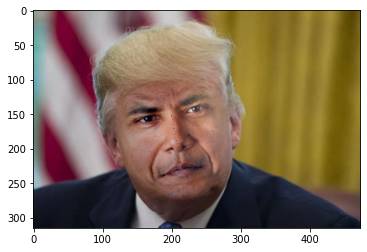

In [42]:
# Gets the center of the face for the body
(x, y, widht, height) = cv2.boundingRect(convexhull2)
center_face2 = (int((x+x+widht)/2), int((y+y+height)/2))

seamlessclone = cv2.seamlessClone(result, body, body_head_mask, center_face2, cv2.NORMAL_CLONE)

plt.imshow(cv2.cvtColor(seamlessclone, cv2.COLOR_BGR2RGB))

cv2.imwrite("./result.png", seamlessclone)

CONCLUSOES